# Training models on campaigns in the same area 
## Operator 2

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import warnings
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from imblearn.over_sampling import SMOTE
from keras.optimizers import Adam
from keras.models import Sequential # type: ignore
from keras.layers import Dense, LSTM, Dropout # type: ignore
from sklearn.preprocessing import MinMaxScaler
import plotly.graph_objects as go
from sklearn.cluster import KMeans
import uuid

In [2]:
rsrp_colors = ['#384959', '#6A89A7', '#88BDF2', '#BDDDFC']
rsrq_colors = ['#614419', '#B37E2E', '#DB9A39', '#FFB343']
sinr_colors = ['#135E4B', '#4CB572', '#A1D8B5', '#CCDCDB']
mode_colors = ['#872323', '#C93636', '#E26666', '#F4B6B6']

plt.rcParams.update({'font.size': 18})

### Prossessing functions

In [3]:
'''
    Reading the dataset and returning two pandas DataFrames:
        The first DataFrame containing every datapoint belonging to the given campaign (if any)
        The second DataFrame containing only one column - the mode (4G or 5G)
'''
def read_dataset(filename, campaigns=None, features=None):
    df = pd.read_csv(filename)
    df = df.loc[:, ~df.columns.str.match('Unnamed')]
    df = df.loc[:, ~df.columns.str.match('Timestamp')]
    df = df.replace('DC', 1)
    df = df.replace('LTE', 0)
    df = df[df['campaign'].str.contains('Driving') | df['campaign'].str.contains('Walking')]

    if campaigns != None:
        df = df[df['campaign'].isin(campaigns)]

    if features == None:
        features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'campaign']

    features.append('Mode')
    features.append('Latitude')
    features.append('Longitude')
    return df[features]

'''
    Returns accuracy, recall and precision
'''
def metrics(y_true, y_pred):
    true_series, pred_series = [], []

    for i in range(len(y_pred)):
        seq_true, seq_pred = y_true[i], y_pred[i]
        for j in range(len(seq_pred)):
            true_series.append(seq_true[j])
            pred_series.append(seq_pred[j])

    return accuracy_score(true_series, pred_series), recall_score(true_series, pred_series), precision_score(true_series, pred_series)

### LSTM functions

In [4]:
'''
    Returns a numpy array of list 
'''
def series_split_sequences(f, t, n_steps_in, n_steps_out):
    X, y = [], []
    curr_campaign = ''
    for i in range(len(f)):
        # find the end of the pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out

        if out_end_ix > len(f):
            break

        if curr_campaign == '': # set new current campaign if there is no campaign
            curr_campaign = f['campaign'].iloc[i]
        seq_x, seq_y = f[i:end_ix], t[end_ix:out_end_ix]
        if f.iloc[i:out_end_ix]['campaign'].nunique() > 1: # check to see if in transition between two campaigns
            continue
        elif curr_campaign != f['campaign'].iloc[i]: # set new campaign equal to current if this is the campaign we are looping through
            curr_campaign = f['campaign'].iloc[i]
        X.append(seq_x.drop('campaign', axis=1))
        y.append(seq_y)

    return np.array(X), np.array(y)


'''
    Returns the mean absolute error on each datapoint
'''
def single_point_mae(y_pred, y_true):
    pred_series, true_series = [], []

    for i in range(len(y_pred)):
        for k in range(len(y_pred[i])):
            pred_series.append(y_pred[i][k])
            true_series.append(y_true[i][k])

    pred_series, true_series = np.array(pred_series), np.array(true_series)

    return np.mean(np.abs(pred_series - true_series)), np.abs(pred_series - true_series)

def long_short_term_memory(train, test, target_feature:str, features:list, n_steps_in=5, n_steps_out=1, units=[5, 10]):

    features.remove('campaign')

    idx_target = features.index(target_feature)

    scaler = MinMaxScaler()
    train[features] = scaler.fit_transform(train[features])
    test[features] = scaler.transform(test[features])

    X, y = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
    X_test, y_test = series_split_sequences(test, test[target_feature], n_steps_in, n_steps_out)

    train_idx = 4 * len(y) // 5

    X_train, y_train = X[0 : train_idx], y[0 : train_idx]
    X_val, y_val = X[train_idx ::], y[train_idx ::]

    opt = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

    model = Sequential()
    if len(units) > 1:
        for unit in units[0:-1]:
            model.add(LSTM(units=unit,
                        activation='relu', recurrent_activation='sigmoid',
                        return_sequences=True, return_state=False
                        ))
            model.add(Dropout(0.2))
    model.add(LSTM(units=units[-1],
                   activation='relu', recurrent_activation='sigmoid',
                   return_sequences=False, return_state=False
                   ))
    model.add(Dropout(0.2))
    model.add(Dense(n_steps_out, activation='sigmoid'))
    model.compile(loss='mse', optimizer=opt)
    
    history = model.fit(X_train, y_train,
              epochs=100,
              validation_data=(X_val, y_val),
              shuffle=True, verbose=0)   

    scaler_pred = MinMaxScaler()
    scaler_pred.min_, scaler_pred.scale_ = scaler.min_[idx_target], scaler.scale_[idx_target]

    y_pred = model.predict(X_test, verbose=0) 

    y_pred = scaler_pred.inverse_transform(y_pred)
    y_true = scaler_pred.inverse_transform(y_test)
    test[features] = scaler.inverse_transform(test[features])

    train_pred = model.predict(X, verbose=0)

    train_pred = scaler_pred.inverse_transform(train_pred)
    train[features] = scaler.inverse_transform(train[features])
    _, test_y_seq = series_split_sequences(train, train[target_feature], n_steps_in, n_steps_out)
        
    mae = single_point_mae(y_pred, y_true)
    train_mae = single_point_mae(train_pred, test_y_seq)

    results = {'y_pred': y_pred,
               'y_true': y_true,
               'train_pred': train_pred,
               'train_true': y_train,
               'loss' : history.history['loss'],
               'loss_final' : round(history.history['loss'][-1], 5),
               'val_loss' : history.history['val_loss'],
               'val_loss_final' : round(history.history['val_loss'][-1], 5),
               'mae': round(mae[0], 2),
               'list_mae': mae[1],
               'train_mae': round(train_mae[0], 2),
               'train_list_mae': train_mae[1]
               }

    return results

def plot_lstm_1_step(pred, true, colors:list, target_feature:str, operator:str, feature_comb:str):
    fig = plt.figure(figsize=(16, 6))
    plt.grid(zorder=0)
    pred = plt.plot(pred, label='Predicted', color=colors[0], zorder=2)
    true = plt.plot(true, label='True', color=colors[2], zorder=1)
    plt.xlabel('Index / Timestamp')
    plt.ylabel(target_feature)
    plt.xlim((0, 200))
    plt.title(f'{operator}\nCombination of training features: {feature_comb}')
    plt.legend(handles=[pred[0], true[0]])
    plt.show()

    return fig

'''
    Plots the mean absolute errors in a boxplot for each signal strength indicator
    Returns a dataframe with mean mae for each timestep for each signal strength indicator
'''
def boxplot_timesteps(results:dict, feature_comb:list, sss_feature_comb:list, n_steps_in:int, n_steps_out:int, operator:str, whiskers=[5, 95], y_lim=None):
    selected_rsrp, selected_sinr, selected_rsrq = feature_comb[0], feature_comb[1], feature_comb[2]
    selected_sss_rsrp, selected_sss_sinr, selected_sss_rsrq = sss_feature_comb[0], sss_feature_comb[1], sss_feature_comb[2]

    rsrp_lstm, sinr_lstm, rsrq_lstm = results[selected_rsrp]['list_mae'], results[selected_sinr]['list_mae'], results[selected_rsrq]['list_mae']
    sss_rsrp_lstm, sss_sinr_lstm, sss_rsrq_lstm = results[selected_sss_rsrp]['list_mae'], results[selected_sss_sinr]['list_mae'], results[selected_sss_rsrq]['list_mae']

    rsrp_lstm_mae, sinr_lstm_mae, rsrq_lstm_mae, sss_rsrp_lstm_mae, sss_sinr_lstm_mae, sss_rsrq_lstm_mae = [], [], [], [], [], []
    mean_rsrp, mean_sinr, mean_rsrq, mean_sss_rsrp, mean_sss_sinr, mean_sss_rsrq = [], [], [], [], [], []

    for i in range(n_steps_out):
        rsrp_lstm_mae.append(rsrp_lstm[:, i])
        mean_rsrp.append(round(np.mean(rsrp_lstm[:, i]), 3))

        sinr_lstm_mae.append(sinr_lstm[:, i])
        mean_sinr.append(round(np.mean(sinr_lstm[:, i]), 3))

        rsrq_lstm_mae.append(rsrq_lstm[:, i])
        mean_rsrq.append(round(np.mean(rsrq_lstm[:, i]), 3))

        sss_rsrp_lstm_mae.append(sss_rsrp_lstm[:, i])
        mean_sss_rsrp.append(round(np.mean(sss_rsrp_lstm[:, i]), 3))

        sss_sinr_lstm_mae.append(sss_sinr_lstm[:, i])
        mean_sss_sinr.append(round(np.mean(sss_sinr_lstm[:, i]), 3))

        sss_rsrq_lstm_mae.append(sss_rsrq_lstm[:, i])
        mean_sss_rsrq.append(round(np.mean(sss_rsrq_lstm[:, i]), 3))
    
    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig, axes = plt.subplots(2, 3, figsize=(18, 16), sharey=True)
    sns.boxplot(data=rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[0, 0], whis=whiskers)
    axes[0, 0].set_title('Mean absolute errors of RSRP')

    sns.boxplot(data=sinr_lstm_mae, color=sinr_colors[2], ax=axes[0, 1], whis=whiskers)
    axes[0, 1].set_title('Mean absolute errors of SINR')

    sns.boxplot(data=rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[0, 2], whis=whiskers)
    axes[0, 2].set_title('Mean absolute errors of RSRQ')

    sns.boxplot(data=sss_rsrp_lstm_mae, color=rsrp_colors[2], ax=axes[1, 0], whis=whiskers)
    axes[1, 0].set_title('Mean absolute errors of SSS-RSRP')

    sns.boxplot(data=sss_sinr_lstm_mae, color=sinr_colors[2], ax=axes[1, 1], whis=whiskers)
    axes[1, 1].set_title('Mean absolute errors of SSS-SINR')

    sns.boxplot(data=sss_rsrq_lstm_mae, color=rsrq_colors[2], ax=axes[1, 2], whis=whiskers)
    axes[1, 2].set_title('Mean absolute errors of SSS-RSRQ')

    axes[0, 0].set_ylim((-0.2, y_lim))

    for ax in axes.flat:
        ax.set_ylabel('Mean Absolute Error')
        ax.set_xlabel('Timestep')
        ax.set_xticks(range(n_steps_out))
        ax.set_xticklabels(labels[0:n_steps_out])
        
    plt.suptitle(f'{n_steps_in} steps in, {n_steps_out} steps out\n{operator}', fontsize=18, fontweight='semibold')

    plt.show()

    means = {
        'RSRP': mean_rsrp,
        'SINR': mean_sinr,
        'RSRQ': mean_rsrq,
        'SSS-RSRP': mean_sss_rsrp,
        'SSS-SINR': mean_sss_sinr,
        'SSS-RSRQ': mean_sss_rsrq
    }

    fig.subplots_adjust(wspace=0.5, hspace=10)

    means = pd.DataFrame(means, index=labels[0:n_steps_out]).T

    return fig, means

### Random Forest functions

In [ ]:
def rf(X_train, X_test, mode_train, mode_test, campaigns:list, test_campaigns:list, features:list, n_steps_in:int, n_steps_out:int, n_estimators=100, max_depth=None, min_samples_leaf=1, preds=[], train_preds__=[]):
    permutation = np.random.permutation(X_train.index)
    X_train_randomized = X_train.reindex(permutation).reset_index(drop=True)
    mode_train_randomized = mode_train.reindex(permutation).reset_index(drop=True)

    rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf=min_samples_leaf)
    smote = SMOTE()
    X_train_balanced, mode_train_balanced = smote.fit_resample(X_train_randomized[features], mode_train_randomized['Mode'])

    rf.fit(X_train_balanced, mode_train_balanced)

    y_pred = []
    preds_pred = []
    train_preds = []
    train_preds_pred = []
    
    if len(preds) == 0 and len(train_preds__) == 0:
        preds_pred = None
        train_preds_pred = None
        if len(test_campaigns) == 1:
            y_pred = rf.predict(X_test[features])

            accuracy = accuracy_score(mode_test['Mode'], y_pred)
            precision = precision_score(mode_test['Mode'], y_pred)
            recall = recall_score(mode_test['Mode'], y_pred)

            y_true = mode_test['Mode']

            train_pred = rf.predict(X_train[features])

            train_accuracy = accuracy_score(mode_train['Mode'], train_pred)
            train_precision = precision_score(mode_train['Mode'], train_pred)
            train_recall = recall_score(mode_train['Mode'], train_pred)

            train_true = mode_train['Mode']
        else:
            X_test_test = X_test[X_test['campaign'] == test_campaigns[0]]
            X_test_mode = mode_test[mode_test['campaign'] == test_campaigns[0]]
            
            y_pred = rf.predict(X_test_test[features])

            y_pred_total = rf.predict(X_test[features])
            accuracy = accuracy_score(mode_test['Mode'], y_pred_total)
            precision = precision_score(mode_test['Mode'], y_pred_total)
            recall = recall_score(mode_test['Mode'], y_pred_total)

            y_true = X_test_mode['Mode']

            X_train_test = X_train[X_train['campaign'] == campaigns[0]]
            X_train_mode = mode_train[mode_train['campaign'] == campaigns[0]]

            train_pred = rf.predict(X_train_test[features])

            train_pred_total = rf.predict(X_train[features])
            train_accuracy = accuracy_score(mode_train['Mode'], train_pred_total)
            train_precision = precision_score(mode_train['Mode'], train_pred_total)
            train_recall = recall_score(mode_train['Mode'], train_pred_total)

            train_true = X_train_mode['Mode']

        pred_accuracy, pred_recall, pred_precision = 0, 0, 0
        train_pred_accuracy, train_pred_recall, train_pred_precision = 0, 0, 0

    else:
        _, y_true = series_split_sequences(X_test, mode_test['Mode'], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, test_seq = series_split_sequences(X_test, X_test[features], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, train_true = series_split_sequences(X_train, mode_train['Mode'], n_steps_in=n_steps_in, n_steps_out=n_steps_out)
        _, train_seq = series_split_sequences(X_train, X_train[features], n_steps_in=n_steps_in, n_steps_out=n_steps_out)

        for i in range(len(test_seq)):
            pred = rf.predict(test_seq[i])
            y_pred.append(pred)
        
        for i in range(len(preds)):
            row = preds.iloc[i]
            row = pd.DataFrame(row.values.tolist(), index=row.index).transpose()
            pred = rf.predict(row)
            preds_pred.append(pred)

        for i in range(len(train_seq)):
            pred = rf.predict(train_seq[i])
            train_preds.append(pred)
        
        for i in range(len(train_preds__)):
            row = train_preds__.iloc[i]
            row = pd.DataFrame(row.values.tolist(), index=row.index).transpose()
            pred = rf.predict(row)
            train_preds_pred.append(pred)
        
        accuracy, recall, precision = metrics(y_true, y_pred)
        train_accuracy, train_recall, train_precision = metrics(train_true, train_preds)
        pred_accuracy, pred_recall, pred_precision = metrics(y_true, preds_pred)
        train_pred_accuracy, train_pred_recall, train_pred_precision = metrics(train_true, train_preds_pred)

    acc = []
    pred_acc = []

    if n_steps_out > 1:
        for i in range(n_steps_out):
            acc.append(accuracy_score(np.array(y_true)[:, i], np.array(y_pred)[:, i]))
            pred_acc.append(accuracy_score(np.array(y_true)[:, i], np.array(preds_pred)[:, i]))
    
    results = {'Accuracy': round(accuracy, 3),
               'Precision': round(precision, 3),
               'Recall': round(recall, 3),
               'y_true' : y_true,
               'y_pred' : y_pred,
               'pred_pred': preds_pred,
               'train_true': train_true,
               'train_pred': train_preds,
               'train_pred_pred':  train_preds_pred,
               'Accuracy_train': round(train_accuracy, 3),
               'Precision_train': round(train_precision, 3),
               'Recall_train': round(train_recall, 3),
               'Accuracy_pred': round(pred_accuracy, 3),
               'Precision_pred': round(pred_recall, 3),
               'Recall_pred': round(pred_precision, 3),
               'Accuracy_train_pred': round(train_pred_accuracy, 3),
               'Recall_train_pred': round(train_pred_recall, 3),
               'Precision_train_pred': round(train_pred_precision, 3),
               'Accuracy_list': acc,
               'Accuracy_pred_list': pred_acc,
               'model': rf}
    return results

def plot_mode(pred, true, preds, operator:str, comb:str, colors=mode_colors, xlim=None):
    fig = plt.figure(figsize=(14, 6))
    plt.plot(preds, color=colors[0], label='Predicted on predicted values', zorder=1)
    plt.plot(np.array(pred) + 2, color=colors[1], label='Predicted on true values', zorder=2)
    plt.plot(np.array(true) + 4, color=colors[3], label='True', zorder=3)
    plt.xlabel('Index / Timestamp')
    plt.ylabel('HO')
    plt.xlim(xlim)
    plt.ylim((-0.2, 6))
    plt.yticks([0, 1, 2, 3, 4, 5], ['4G', '5G', '4G', '5G', '4G', '5G'])
    plt.title(f'{operator}\nParameters: {comb}')
    plt.legend(ncols=3, loc='best')
    plt.tight_layout()
    plt.show()

    return fig

'''
    Plots the accuracy for each timestep ahead for test and pred
'''
def boxplot_accuracies(results:dict, n_steps_out:str, n_steps_in:str, whiskers=[0, 100]):
    accuracy = [[] for _ in range(n_steps_out)]
    accuracy_pred = [[] for _ in range(n_steps_out)]

    for key in results:
        for i in range(n_steps_out):
            accuracy[i].append(results[key]['Accuracy_list'][i])
            accuracy_pred[i].append(results[key]['Accuracy_pred_list'][i])
    
    df_combined = pd.DataFrame(columns=['Accuracy', 'Timestep', 'Values'])
    for i in range(n_steps_out):
        for acc in accuracy[i]:
            new_row = {'Accuracy': acc, 'Timestep': i, 'Values': 'Test'}
            df_combined = pd.concat([df_combined, pd.DataFrame([new_row])], ignore_index=True)
        for acc in accuracy_pred[i]:
            new_row = {'Accuracy': acc, 'Timestep': i, 'Values': 'Predicted'}
            df_combined = pd.concat([df_combined, pd.DataFrame([new_row])], ignore_index=True)

    labels = ['1st', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th', '11th', '12th', '13th', '14th', '15th', '16th', '17th', '18th', '19th', '20th']

    fig = plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_combined, x='Timestep', y='Accuracy', hue='Values', palette=[sns.color_palette('Greens')[1], sns.color_palette('Greens')[3]], whis=whiskers, zorder=2)
    plt.title(f'Accuracy per time step with look-back of {n_steps_in}')
    plt.ylabel('Accuracy')
    plt.xlabel('Steps ahead')
    plt.xticks(range(n_steps_out), labels[0:n_steps_out])
    plt.grid(zorder=0)
    plt.tight_layout()
    plt.show()
    return fig

In [ ]:
# Parameters
tf.random.set_seed(4567)
dataset = 'datasets/Op2_merged.csv'
operator = 'Operator 2'

# LSTM
n_steps_in, n_steps_out = 5, 1
units = [10, 10]

# Random Forest
n_estimators = 100
max_depth = 10

### Overlapping campaigns

- Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode, Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode, Capacity_Ookla_4G5G_Vodafone_Driving_Viale_Marconi, (Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode)

- Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia, Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight, Ping_8888_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia_No_Flight_Mode, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight, Capacity_Ookla_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia__Test_2_No_Flight_Mode

- Ping_UNIDATA_4G5G_Vodafone_Walking_Fornetto_Durant_Gianicolense, Ping_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense_No_Flight, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense, (Ping_UNIDATA_4G5G_Vodafone_Driving_Vatican_Area_to_Sabino_Route_2_No_Flight_Mode), (Ping_8888_4G5G_Vodafone_Walkong_Sabino_to_Stat_Trastevere, Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Sabino_to_Stat_Trastevere_Test_2)

- Ping_UNIDATA_4G5G_Vodafone_Driving_Luca, Interactivity_gaming_4G5G_Vodafone_Driving_Luca, Capacity_Ookla_4G5G_Vodafone_Driving_Luca

In [7]:

overlap_1 = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi_Test_2_No_Flight_Mode', 
             'Ping_8888_4G5G_Vodafone_Driving_Viale_Marconi_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Viale_Marconi', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End_to_Eur_Palasport_No_Flight_Mode']

overlap_2 = ['Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia', 
             'Ping_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight', 
             'Ping_8888_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia_No_Flight_Mode', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Tuscolana_Stat_Appia_Test_2_No_Flight', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Tuscolana_Stat_Appia__Test_2_No_Flight_Mode']

overlap_3 = ['Ping_UNIDATA_4G5G_Vodafone_Walking_Fornetto_Durant_Gianicolense', 
             'Ping_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense_No_Flight', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_Fornetto_Durant_Gianicolense', 
             'Ping_UNIDATA_4G5G_Vodafone_Driving_Vatican_Area_to_Sabino_Route_2_No_Flight_Mode', 
             'Ping_8888_4G5G_Vodafone_Walkong_Sabino_to_Stat_Trastevere', 
             'Capacity_Ookla_UNIDATA_4G5G_Vodafone_Walking_Sabino_to_Stat_Trastevere_Test_2']

overlap_4 = ['Ping_UNIDATA_4G5G_Vodafone_Driving_Luca', 
             'Interactivity_gaming_4G5G_Vodafone_Driving_Luca', 
             'Capacity_Ookla_4G5G_Vodafone_Driving_Luca']

## Prepare geodata

In [8]:
df = read_dataset(dataset, campaigns=overlap_1[0:3])

# only a part of this route overlaps with the others
route_to_add = read_dataset(dataset, campaigns=[overlap_1[3]])
df = pd.concat([route_to_add[5350::], df])
df.reset_index(drop=True, inplace=True)

df['ID'] = [str(uuid.uuid4()) for _ in range(len(df))]
X = df.loc[:, ['ID','Latitude','Longitude']]

In [9]:
kmeans = KMeans(n_clusters=35, init='k-means++')

kmeans.fit(X[['Latitude', 'Longitude']])
X['k_area'] = kmeans.fit_predict(X[['Latitude', 'Longitude']])
centers = kmeans.cluster_centers_
labels = kmeans.predict(X[['Latitude', 'Longitude']])

clustered_df = df.merge(X, left_on='ID', right_on='ID')
clustered_df = clustered_df.drop(['Latitude_x', 'Longitude_x', 'Latitude_y', 'Longitude_y', 'ID'], axis=1)
clustered_df

RSRP  SINR   RSRQ  SSS_RSRP  SSS_SINR  SSS_RSRQ  \
0     -109.13  4.79 -19.73    -112.1       3.3     -12.6   
1     -109.13  4.79 -19.73    -112.1       3.3     -12.6   
2     -109.13  4.79 -19.73    -112.1       3.3     -12.6   
3     -109.13  4.79 -19.73    -112.1       3.3     -12.6   
4     -107.06  4.83 -17.18    -116.8      -2.8     -15.0   
...       ...   ...    ...       ...       ...       ...   
10328  -93.82  3.00 -17.38    -118.2      -1.6     -15.0   
10329  -93.82  3.00 -17.38    -118.2      -1.6     -15.0   
10330  -93.82  3.00 -17.38    -118.2      -1.6     -15.0   
10331  -93.82  3.00 -17.38    -118.2      -1.6     -15.0   
10332  -93.82  3.00 -17.38    -118.2      -1.6     -15.0   

                                                campaign  Mode  k_area  
0      Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...     1       0  
1      Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...     1       0  
2      Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...     1       0  
3      Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...     1       0  
4      Capacity_Ookla_4G5G_Vodafone_Driving_Appia_End...     1       0  
...                                                  ...   ...     ...  
10328  Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...     0      15  
10329  Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...     0      15  
10330  Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...     0      15  
10331  Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...     0      15  
10332  Capacity_Ookla_UNIDATA_4G5G_Vodafone_Driving_V...     0      15  

[10333 rows x 9 columns]

## LSTM

In [10]:
train = clustered_df[clustered_df['campaign'] == overlap_1[1]]
test = clustered_df[clustered_df['campaign'] == overlap_1[0]]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [11]:
target_features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feature_selection = [['RSRP'], ['SINR'], ['RSRQ'], 
                    #  ['RSRP', 'SINR'], ['RSRP', 'RSRQ'], ['SINR', 'RSRQ'], ['RSRP', 'SINR', 'RSRQ'],
                     ['SSS_RSRP'], ['SSS_SINR'], ['SSS_RSRQ'],
                    #  ['SSS_RSRP', 'SSS_SINR'], ['SSS_RSRP', 'SSS_RSRQ'], ['SSS_SINR', 'SSS_RSRQ'], ['SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ'],
                     ['RSRP', 'SSS_RSRP'], ['SINR', 'SSS_SINR'], ['RSRQ', 'SSS_RSRQ']]#, 
                    #  ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']]

lstm_results_1camp = {}

In [12]:
for target in target_features:
    for features in feature_selection:
        if features.__contains__(target):
            used_features = ''
            if len(features) == 6:
                used_features = 'All'
            else:
                used_features = ', '.join(features)
            used_features = used_features + ' -> ' + target
            features.append('campaign')
            warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
            lstm_results_1camp[used_features] = long_short_term_memory(train=train[features], test=test[features], target_feature=target, features=features, n_steps_in=n_steps_in, n_steps_out=n_steps_out, units=units)

In [13]:
df_lstm_results = pd.DataFrame.from_dict(lstm_results_1camp, orient='index')

df_lstm_results.reset_index(inplace=True)
df_lstm_results.rename(columns={'index': 'Combination'}, inplace=True)
df_lstm_results = df_lstm_results.drop(['y_pred', 'y_true', 'train_pred', 'train_true', 'loss', 'val_loss', 'list_mae', 'train_list_mae'], axis=1)
df_lstm_results

Combination  loss_final  val_loss_final   mae  train_mae
0                 RSRP -> RSRP     0.00543         0.00758  2.02       1.88
1       RSRP, SSS_RSRP -> RSRP     0.00603         0.00129  1.20       0.82
2                 SINR -> SINR     0.00307         0.00069  1.86       1.23
3       SINR, SSS_SINR -> SINR     0.00281         0.00028  0.78       0.60
4                 RSRQ -> RSRQ     0.00583         0.00312  0.88       0.97
5       RSRQ, SSS_RSRQ -> RSRQ     0.00497         0.00159  0.47       0.50
6         SSS_RSRP -> SSS_RSRP     0.00546         0.00326  2.13       1.57
7   RSRP, SSS_RSRP -> SSS_RSRP     0.00538         0.00442  3.49       2.86
8         SSS_SINR -> SSS_SINR     0.00874         0.00362  2.56       1.99
9   SINR, SSS_SINR -> SSS_SINR     0.00671         0.00437  3.67       2.93
10        SSS_RSRQ -> SSS_RSRQ     0.00655         0.00437  1.01       0.92
11  RSRQ, SSS_RSRQ -> SSS_RSRQ     0.00581         0.00399  0.91       0.84

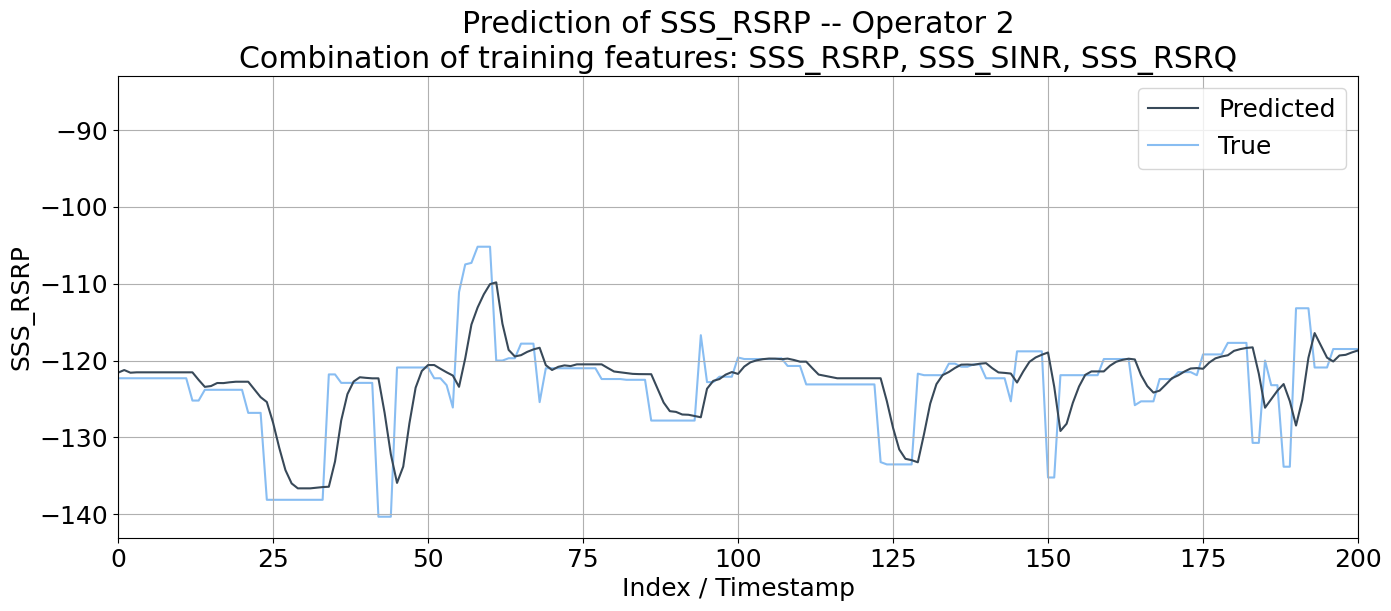

In [14]:
selected_sss_rsrp_comb = 'RSRP, SSS_RSRP -> SSS_RSRP'
sss_rsrp_comb = lstm_results_1camp[selected_sss_rsrp_comb]
sss_rsrp_pred = sss_rsrp_comb['y_pred']
sss_rsrp_true = sss_rsrp_comb['y_true']
sss_rsrp_train_pred = sss_rsrp_comb['train_pred']
sss_rsrp_train_true = sss_rsrp_comb['train_true']

f = plt.figure(figsize=(16, 6))
plt.grid(zorder=0)
pred = plt.plot(sss_rsrp_pred, label='Predicted', color=rsrp_colors[0], zorder=2)
true = plt.plot(sss_rsrp_true, label='True', color=rsrp_colors[2], zorder=1)
plt.xlabel('Index / Timestamp')
plt.ylabel('SSS_RSRP')
plt.xlim((0, 200))
plt.title(f'Prediction of SSS_RSRP -- {operator}\nCombination of training features: SSS_RSRP, SSS_SINR, SSS_RSRQ')
plt.legend(handles=[pred[0], true[0]])
plt.show()

## Random Forest

In [15]:
est_try = [5, 10, 50, 100, 120, 150, 200]
min_leaf_size = [1, 5, 10, 15]

### Overlap 1

In [16]:
feature_comb = ['RSRP -> RSRP', 'SINR -> SINR', 'RSRQ -> RSRQ']
sss_feature_comb = ['SSS_RSRP -> SSS_RSRP', 'SSS_SINR -> SSS_SINR', 'SSS_RSRQ -> SSS_RSRQ']

lstm_preds_1camp = pd.DataFrame({'RSRP': lstm_results_1camp[feature_comb[0]]['y_pred'][:, 0].tolist(),
                                  'SINR': lstm_results_1camp[feature_comb[1]]['y_pred'][:, 0].tolist(),
                                  'RSRQ': lstm_results_1camp[feature_comb[2]]['y_pred'][:, 0].tolist(),
                                  'SSS_RSRP': lstm_results_1camp[sss_feature_comb[0]]['y_pred'][:, 0].tolist(),
                                  'SSS_SINR': lstm_results_1camp[sss_feature_comb[1]]['y_pred'][:, 0].tolist(),
                                  'SSS_RSRQ': lstm_results_1camp[sss_feature_comb[2]]['y_pred'][:, 0].tolist(),
                                  'k_area': test['k_area'][n_steps_in::].tolist()},
                                  columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

lstm_pred_train_1camp = pd.DataFrame({'RSRP': lstm_results_1camp[feature_comb[0]]['train_pred'][:, 0].tolist(),
                                       'SINR': lstm_results_1camp[feature_comb[1]]['train_pred'][:, 0].tolist(),
                                       'RSRQ': lstm_results_1camp[feature_comb[2]]['train_pred'][:, 0].tolist(),
                                       'SSS_RSRP': lstm_results_1camp[sss_feature_comb[0]]['train_pred'][:, 0].tolist(),
                                       'SSS_SINR': lstm_results_1camp[sss_feature_comb[1]]['train_pred'][:, 0].tolist(),
                                       'SSS_RSRQ': lstm_results_1camp[sss_feature_comb[2]]['train_pred'][:, 0].tolist(),
                                       'k_area': train['k_area'][n_steps_in::].tolist()},
                                       columns=['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ', 'k_area'])

#### Train 1 campaign -- Test 1 campaign

In [17]:
rf_results_1camp = {}
feats = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feats.append('campaign')
features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results_1camp[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, preds=lstm_preds_1camp[features], train_preds__=lstm_pred_train_1camp[features], n_steps_in=5, n_steps_out=1)

df_rf_results = pd.DataFrame.from_dict(rf_results_1camp, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.614      0.807   0.556           0.998   
1      n_est: 5, min_leaf: 5     0.639      0.814   0.596           0.994   
2     n_est: 5, min_leaf: 10     0.647      0.866   0.559           0.988   
3     n_est: 5, min_leaf: 15     0.639      0.826   0.584           0.979   
4     n_est: 10, min_leaf: 1     0.639      0.875   0.538           0.998   
5     n_est: 10, min_leaf: 5     0.618      0.823   0.547           0.996   
6    n_est: 10, min_leaf: 10     0.644      0.885   0.537           0.989   
7    n_est: 10, min_leaf: 15     0.659      0.875   0.573           0.982   
8     n_est: 50, min_leaf: 1     0.641      0.859   0.554           0.999   
9     n_est: 50, min_leaf: 5     0.662      0.870   0.583           0.995   
10   n_est: 50, min_leaf: 10     0.655      0.871   0.568           0.992   
11   n_est: 50, min_leaf: 15     0.655      0.867   0.572           0.982   
12   n_est: 100, min_leaf: 1     0.654      0.880   0.560           0.999   
13   n_est: 100, min_leaf: 5     0.662      0.881   0.572           0.995   
14  n_est: 100, min_leaf: 10     0.655      0.873   0.567           0.990   
15  n_est: 100, min_leaf: 15     0.668      0.901   0.566           0.982   
16   n_est: 120, min_leaf: 1     0.654      0.876   0.563           0.999   
17   n_est: 120, min_leaf: 5     0.663      0.884   0.571           0.995   
18  n_est: 120, min_leaf: 10     0.660      0.889   0.562           0.994   
19  n_est: 120, min_leaf: 15     0.650      0.874   0.558           0.989   
20   n_est: 150, min_leaf: 1     0.641      0.850   0.562           0.999   
21   n_est: 150, min_leaf: 5     0.667      0.886   0.576           0.997   
22  n_est: 150, min_leaf: 10     0.658      0.890   0.559           0.991   
23  n_est: 150, min_leaf: 15     0.661      0.895   0.558           0.988   
24   n_est: 200, min_leaf: 1     0.657      0.878   0.566           0.999   
25   n_est: 200, min_leaf: 5     0.655      0.874   0.566           0.995   
26  n_est: 200, min_leaf: 10     0.662      0.882   0.570           0.993   
27  n_est: 200, min_leaf: 15     0.667      0.900   0.565           0.991   

    Precision_train  Recall_train  Accuracy_pred  Precision_pred  Recall_pred  \
0             0.998         0.999          0.609           0.567        0.790   
1             0.993         0.997          0.612           0.571        0.791   
2             0.988         0.990          0.639           0.579        0.831   
3             0.979         0.985          0.612           0.596        0.772   
4             0.998         0.998          0.622           0.543        0.834   
5             0.996         0.997          0.629           0.543        0.848   
6             0.987         0.993          0.616           0.553        0.812   
7             0.981         0.986          0.662           0.581        0.872   
8             0.998         0.999          0.618           0.554        0.817   
9             0.993         0.998          0.643           0.579        0.838   
10            0.992         0.994          0.645           0.573        0.848   
11            0.984         0.985          0.660           0.583        0.865   
12            0.998         0.999          0.628           0.561        0.827   
13            0.995         0.997          0.653           0.579        0.857   
14            0.989         0.993          0.633           0.570        0.829   
15            0.980         0.987          0.653           0.567        0.868   
16            0.998         0.999          0.631           0.560        0.834   
17            0.995         0.997          0.652           0.565        0.869   
18            0.994         0.995          0.645           0.565        0.856   
19            0.990         0.990          0.632           0.572        0.825   
20            0.998         0.999          0.628           0.564        0.824   
21

In [18]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.652
Mean precision: 0.870
Mean recall: 0.565


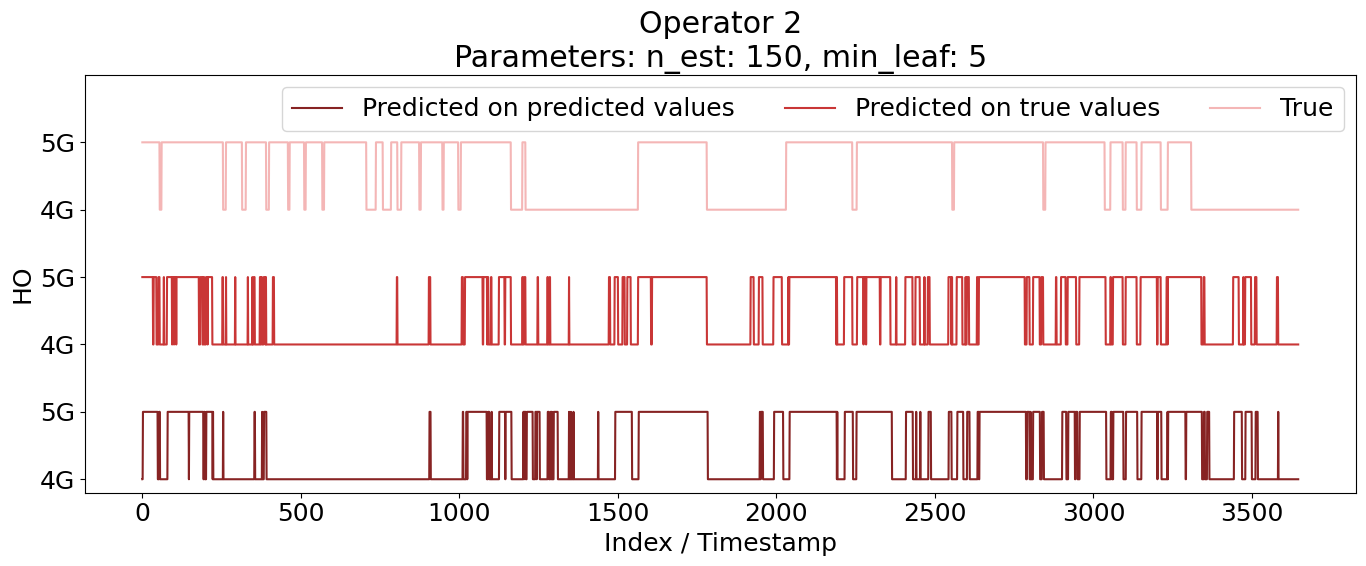

In [19]:
selected_rf_comb = 'n_est: 150, min_leaf: 5'
rf_comb = rf_results_1camp[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']
pred_pred = rf_comb['pred_pred']

fig = plot_mode(pred=rf_pred, true=rf_true, preds=pred_pred, operator=operator, comb=selected_rf_comb)
fig.savefig(r'../latex/plots/rf/op2_1campaign.pdf')

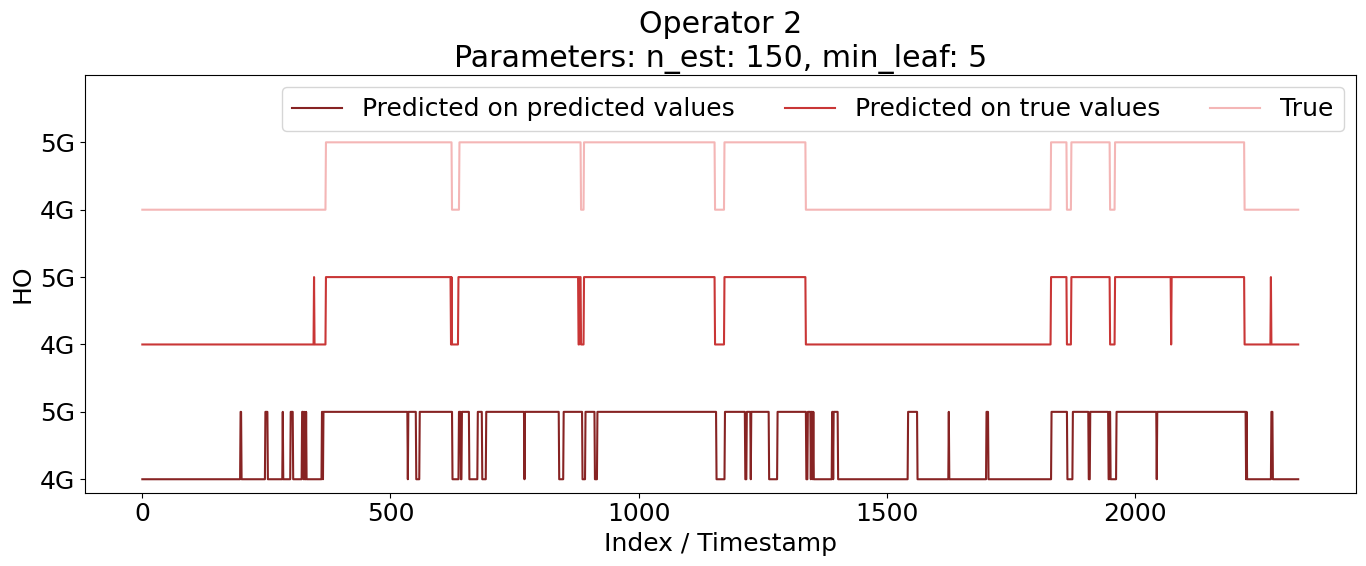

In [20]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']
rf_pred_pred_train = rf_comb['train_pred_pred']

fig = plot_mode(pred=rf_pred_train, true=rf_true_train, preds=rf_pred_pred_train, operator=operator, comb=selected_rf_comb)

#### Include location

In [21]:
rf_results_1camp_loc = {}
feats = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feats.extend(['campaign', 'k_area'])
features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
features.extend(['k_area'])

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results_1camp_loc[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, preds=lstm_preds_1camp, train_preds__=lstm_pred_train_1camp, n_steps_in=5, n_steps_out=1)

df_rf_results = pd.DataFrame.from_dict(rf_results_1camp_loc, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.664      0.905   0.557           0.998   
1      n_est: 5, min_leaf: 5     0.644      0.818   0.602           0.995   
2     n_est: 5, min_leaf: 10     0.647      0.850   0.574           0.991   
3     n_est: 5, min_leaf: 15     0.670      0.883   0.585           0.981   
4     n_est: 10, min_leaf: 1     0.639      0.856   0.553           0.999   
5     n_est: 10, min_leaf: 5     0.677      0.851   0.627           0.997   
6    n_est: 10, min_leaf: 10     0.658      0.850   0.593           0.992   
7    n_est: 10, min_leaf: 15     0.624      0.822   0.559           0.988   
8     n_est: 50, min_leaf: 1     0.662      0.889   0.566           0.999   
9     n_est: 50, min_leaf: 5     0.660      0.881   0.569           0.996   
10   n_est: 50, min_leaf: 10     0.662      0.880   0.573           0.995   
11   n_est: 50, min_leaf: 15     0.665      0.892   0.568           0.991   
12   n_est: 100, min_leaf: 1     0.655      0.886   0.556           0.999   
13   n_est: 100, min_leaf: 5     0.665      0.876   0.582           0.996   
14  n_est: 100, min_leaf: 10     0.667      0.889   0.573           0.990   
15  n_est: 100, min_leaf: 15     0.667      0.895   0.568           0.985   
16   n_est: 120, min_leaf: 1     0.662      0.872   0.580           0.999   
17   n_est: 120, min_leaf: 5     0.667      0.888   0.576           0.997   
18  n_est: 120, min_leaf: 10     0.666      0.900   0.564           0.995   
19  n_est: 120, min_leaf: 15     0.677      0.910   0.574           0.985   
20   n_est: 150, min_leaf: 1     0.659      0.882   0.566           0.999   
21   n_est: 150, min_leaf: 5     0.661      0.883   0.568           0.996   
22  n_est: 150, min_leaf: 10     0.666      0.886   0.575           0.993   
23  n_est: 150, min_leaf: 15     0.672      0.898   0.575           0.988   
24   n_est: 200, min_leaf: 1     0.649      0.868   0.560           0.999   
25   n_est: 200, min_leaf: 5     0.671      0.893   0.577           0.996   
26  n_est: 200, min_leaf: 10     0.667      0.898   0.568           0.993   
27  n_est: 200, min_leaf: 15     0.668      0.896   0.570           0.986   

    Precision_train  Recall_train  Accuracy_pred  Precision_pred  Recall_pred  \
0             0.998         0.999          0.652           0.567        0.866   
1             0.994         0.997          0.625           0.577        0.807   
2             0.991         0.992          0.624           0.577        0.805   
3             0.991         0.975          0.679           0.602        0.881   
4             0.998         0.999          0.623           0.531        0.849   
5             0.995         0.999          0.685           0.641        0.852   
6             0.992         0.995          0.657           0.609        0.833   
7             0.986         0.992          0.636           0.582        0.821   
8             0.998         0.999          0.657           0.565        0.879   
9             0.994         0.999          0.666           0.579        0.882   
10            0.997         0.995          0.652           0.589        0.844   
11            0.994         0.991          0.665           0.576        0.883   
12            0.998         0.999          0.656           0.570        0.871   
13            0.995         0.998          0.645           0.583        0.837   
14            0.985         0.998          0.655           0.571        0.867   
15            0.984         0.988          0.667           0.578        0.884   
16            0.998         0.999          0.655           0.579        0.859   
17            0.996         0.998          0.657           0.581        0.861   
18            0.994         0.998          0.670           0.574        0.895   
19            0.984         0.990          0.669           0.584        0.881   
20            0.998         0.999          0.652           0.575        0.858   
21

In [22]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.661
Mean precision: 0.878
Mean recall: 0.574


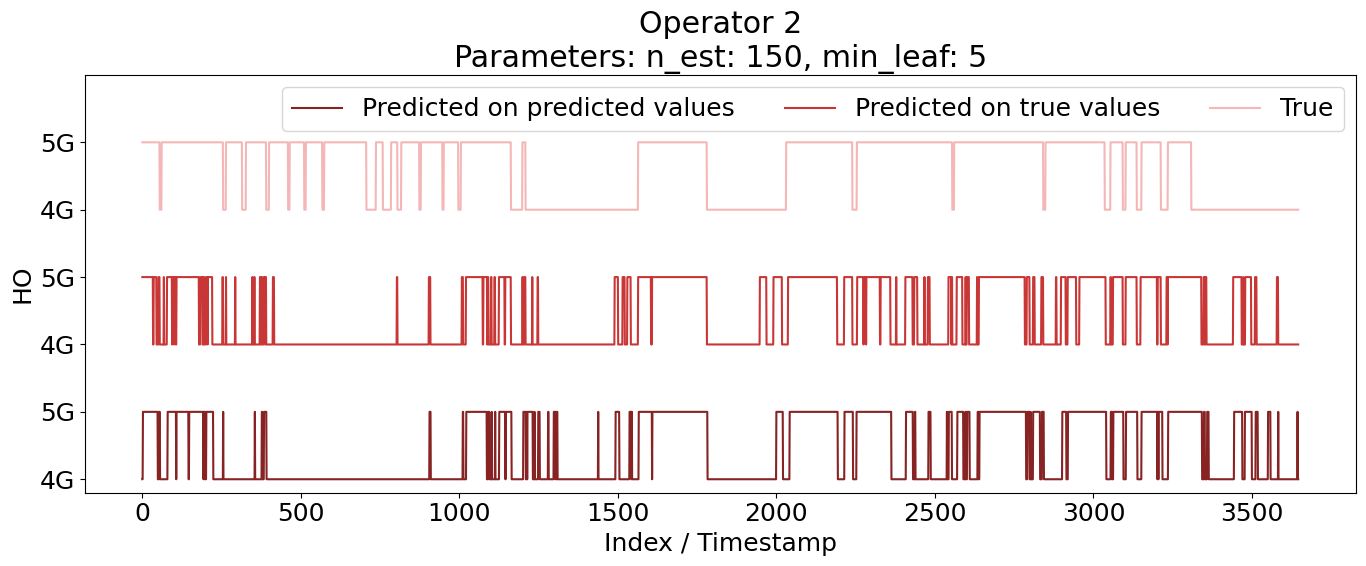

In [23]:
selected_rf_comb = 'n_est: 150, min_leaf: 5'
rf_comb = rf_results_1camp_loc[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']
pred_pred = rf_comb['pred_pred']

fig = plot_mode(pred=rf_pred, true=rf_true, preds=pred_pred, operator=operator, comb=selected_rf_comb)
fig.savefig(r'../latex/plots/rf_loc/op2_1campaign_loc.pdf')

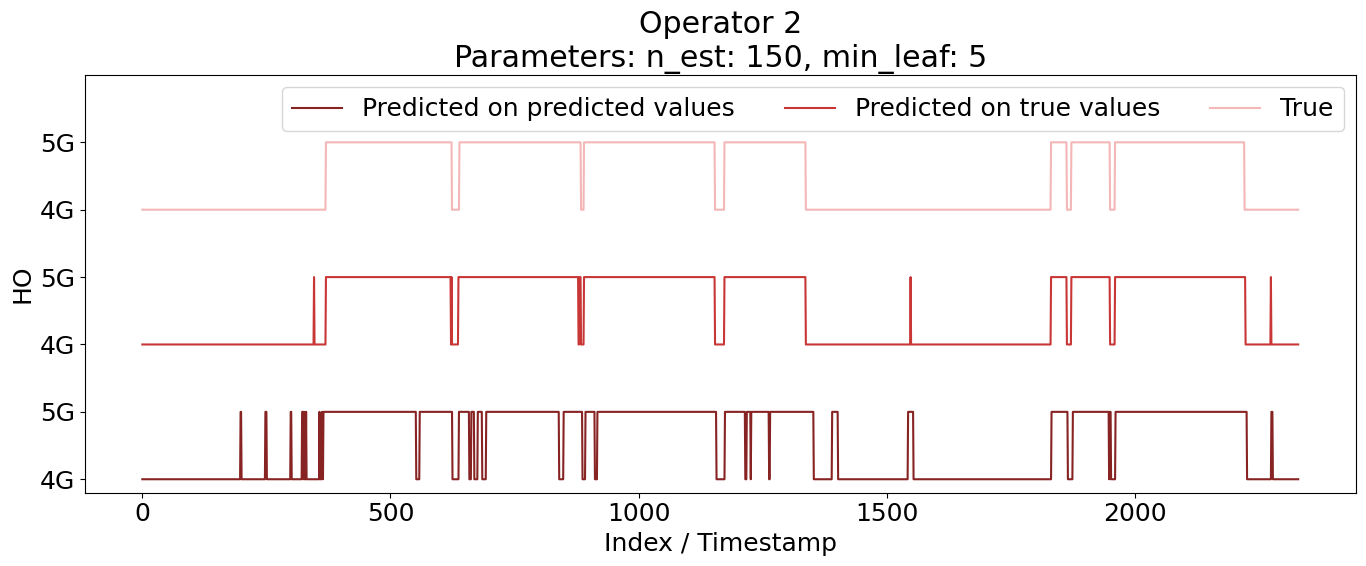

In [24]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']
rf_pred_pred_train = rf_comb['train_pred_pred']

fig = plot_mode(pred=rf_pred_train, true=rf_true_train, preds=rf_pred_pred_train, operator=operator, comb=selected_rf_comb)

#### Train 2 campaigns -- Test 1 campaign

In [27]:
train = clustered_df[clustered_df['campaign'].isin(overlap_1[1:3])]
test = clustered_df[clustered_df['campaign'] == overlap_1[0]]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [28]:
rf_results_2camp = {}
feats = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feats.append('campaign')
features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results_2camp[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, preds=lstm_preds_1camp[features], train_preds__=lstm_pred_train_1camp[features], n_steps_in=5, n_steps_out=1)

df_rf_results = pd.DataFrame.from_dict(rf_results_2camp, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  \
0      n_est: 5, min_leaf: 1     0.653      0.864   0.572   
1      n_est: 5, min_leaf: 5     0.666      0.879   0.581   
2     n_est: 5, min_leaf: 10     0.661      0.895   0.558   
3     n_est: 5, min_leaf: 15     0.674      0.877   0.597   
4     n_est: 10, min_leaf: 1     0.637      0.899   0.516   
5     n_est: 10, min_leaf: 5     0.648      0.874   0.553   
6    n_est: 10, min_leaf: 10     0.670      0.915   0.559   
7    n_est: 10, min_leaf: 15     0.655      0.835   0.603   
8     n_est: 50, min_leaf: 1     0.655      0.895   0.548   
9     n_est: 50, min_leaf: 5     0.655      0.887   0.556   
10   n_est: 50, min_leaf: 10     0.668      0.913   0.556   
11   n_est: 50, min_leaf: 15     0.676      0.904   0.577   
12   n_est: 100, min_leaf: 1     0.646      0.886   0.541   
13   n_est: 100, min_leaf: 5     0.665      0.898   0.563   
14  n_est: 100, min_leaf: 10     0.684      0.903   0.592   
15  n_est: 100, min_leaf: 15     0.677      0.902   0.580   
16   n_est: 120, min_leaf: 1     0.652      0.890   0.548   
17   n_est: 120, min_leaf: 5     0.664      0.904   0.557   
18  n_est: 120, min_leaf: 10     0.672      0.902   0.571   
19  n_est: 120, min_leaf: 15     0.682      0.912   0.582   
20   n_est: 150, min_leaf: 1     0.651      0.892   0.543   
21   n_est: 150, min_leaf: 5     0.669      0.902   0.567   
22  n_est: 150, min_leaf: 10     0.668      0.903   0.564   
23  n_est: 150, min_leaf: 15     0.689      0.924   0.583   
24   n_est: 200, min_leaf: 1     0.656      0.891   0.555   
25   n_est: 200, min_leaf: 5     0.659      0.898   0.553   
26  n_est: 200, min_leaf: 10     0.672      0.916   0.561   
27  n_est: 200, min_leaf: 15     0.677      0.915   0.570   

                                            pred_pred  \
0   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
1   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
2   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
3   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
4   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
5   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
6   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
7   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
8   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
9   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
10  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
11  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
12  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
13  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
14  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
15  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
16  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
17  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
18  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
19  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
20  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
21  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
22  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
23  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
24  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
25  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
26  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
27  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   

                                      train_pred_pred  Accuracy_train  \
0   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.999   
1   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.993   
2   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.989   
3   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.983   
4   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.999   
5   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.995   
6   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.993   
7   [[0], 

In [29]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.664
Mean precision: 0.896
Mean recall: 0.565


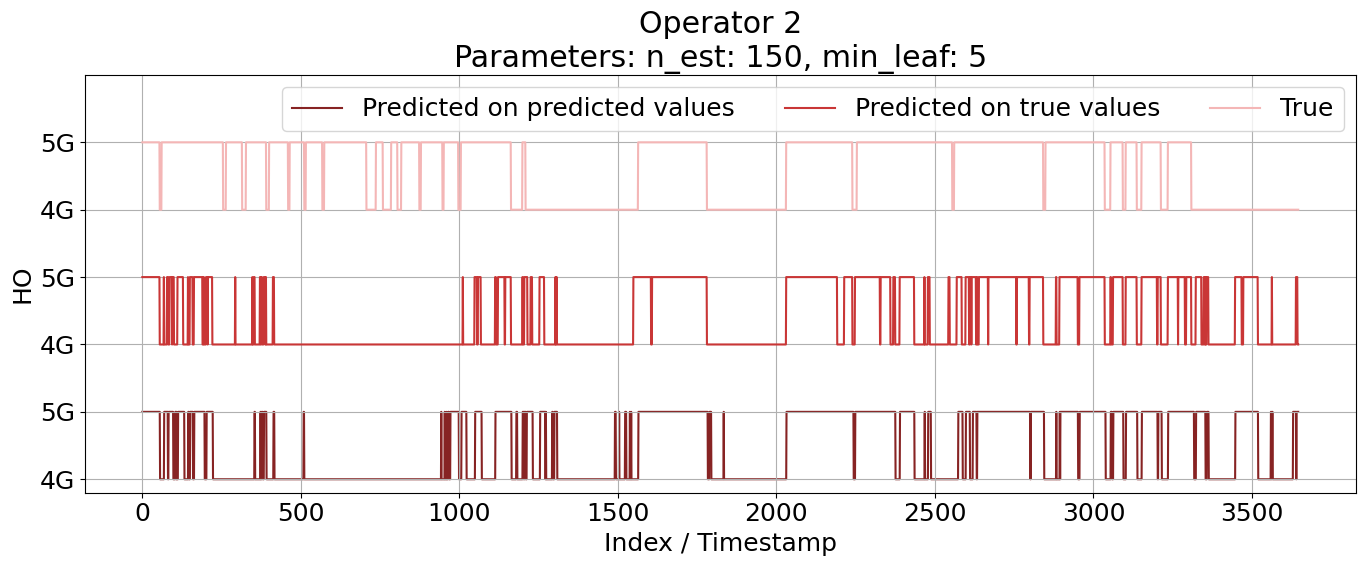

In [30]:
selected_rf_comb = 'n_est: 150, min_leaf: 5'
rf_comb = rf_results_2camp[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']
pred_pred = rf_comb['pred_pred']

fig = plot_mode(pred=rf_pred, true=rf_true, preds=pred_pred, operator=operator, comb=selected_rf_comb)
fig.savefig(r'../latex/plots/rf/op2_2campaign.pdf')

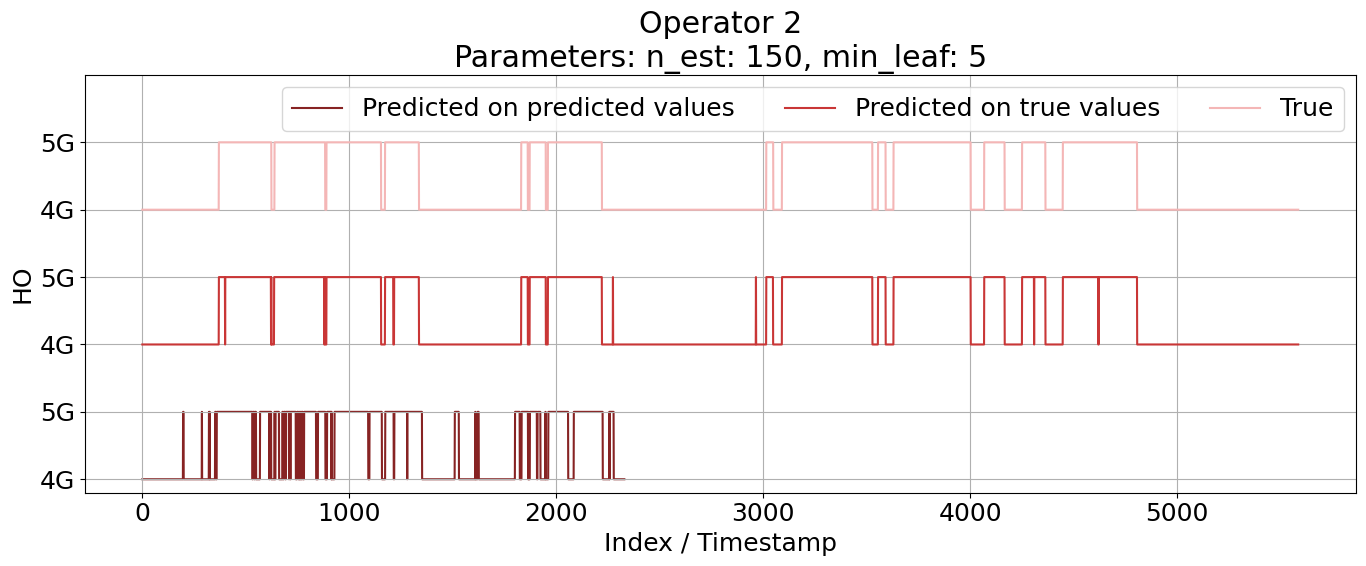

In [32]:
rf_pred_train = rf_comb['train_pred']
rf_true_train = rf_comb['train_true']
rf_pred_pred_train = rf_comb['train_pred_pred']

fig = plot_mode(pred=rf_pred_train, true=rf_true_train, preds=rf_pred_pred_train, operator=operator, comb=selected_rf_comb)

#### Include location

In [33]:
rf_results_2camp_loc = {}
feats = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feats.extend(['campaign', 'k_area'])
features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
features.extend(['k_area'])

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results_2camp_loc[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, preds=lstm_preds_1camp, train_preds__=lstm_pred_train_1camp, n_steps_in=5, n_steps_out=1)

df_rf_results = pd.DataFrame.from_dict(rf_results_2camp_loc, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.658      0.871   0.575           0.999   
1      n_est: 5, min_leaf: 5     0.715      0.889   0.656           0.996   
2     n_est: 5, min_leaf: 10     0.691      0.891   0.613           0.990   
3     n_est: 5, min_leaf: 15     0.677      0.878   0.601           0.979   
4     n_est: 10, min_leaf: 1     0.657      0.904   0.545           0.999   
5     n_est: 10, min_leaf: 5     0.695      0.864   0.647           0.997   
6    n_est: 10, min_leaf: 10     0.671      0.854   0.613           0.992   
7    n_est: 10, min_leaf: 15     0.711      0.871   0.667           0.984   
8     n_est: 50, min_leaf: 1     0.665      0.872   0.585           0.999   
9     n_est: 50, min_leaf: 5     0.672      0.871   0.598           0.997   
10   n_est: 50, min_leaf: 10     0.687      0.897   0.601           0.992   
11   n_est: 50, min_leaf: 15     0.686      0.875   0.620           0.989   
12   n_est: 100, min_leaf: 1     0.681      0.874   0.611           0.999   
13   n_est: 100, min_leaf: 5     0.678      0.869   0.611           0.998   
14  n_est: 100, min_leaf: 10     0.700      0.879   0.640           0.993   
15  n_est: 100, min_leaf: 15     0.705      0.890   0.638           0.989   
16   n_est: 120, min_leaf: 1     0.672      0.877   0.592           0.999   
17   n_est: 120, min_leaf: 5     0.686      0.875   0.620           0.998   
18  n_est: 120, min_leaf: 10     0.700      0.890   0.629           0.992   
19  n_est: 120, min_leaf: 15     0.713      0.882   0.659           0.988   
20   n_est: 150, min_leaf: 1     0.664      0.881   0.575           0.999   
21   n_est: 150, min_leaf: 5     0.673      0.874   0.598           0.998   
22  n_est: 150, min_leaf: 10     0.679      0.882   0.600           0.993   
23  n_est: 150, min_leaf: 15     0.705      0.880   0.647           0.989   
24   n_est: 200, min_leaf: 1     0.674      0.884   0.590           0.999   
25   n_est: 200, min_leaf: 5     0.695      0.885   0.626           0.998   
26  n_est: 200, min_leaf: 10     0.694      0.884   0.625           0.993   
27  n_est: 200, min_leaf: 15     0.706      0.885   0.645           0.989   

    Precision_train  Recall_train  Accuracy_pred  Precision_pred  Recall_pred  \
0             0.999         0.999          0.650           0.561        0.868   
1             0.997         0.994          0.723           0.689        0.869   
2             0.991         0.988          0.669           0.645        0.822   
3             0.980         0.978          0.707           0.664        0.867   
4             0.999         0.999          0.694           0.620        0.889   
5             0.997         0.996          0.690           0.671        0.834   
6             0.991         0.992          0.685           0.652        0.843   
7             0.982         0.985          0.702           0.695        0.831   
8             0.999         0.999          0.670           0.620        0.846   
9             0.999         0.996          0.688           0.650        0.849   
10            0.994         0.991          0.687           0.635        0.861   
11            0.989         0.989          0.688           0.659        0.840   
12            0.999         0.999          0.687           0.634        0.860   
13            0.999         0.997          0.679           0.650        0.834   
14            0.995         0.991          0.707           0.673        0.858   
15            0.988         0.989          0.709           0.682        0.854   
16            0.999         0.999          0.670           0.625        0.840   
17            0.999         0.997          0.703           0.674        0.851   
18            0.993         0.991          0.709           0.672        0.862   
19            0.988         0.989          0.705           0.676        0.853   
20            0.999         0.999          0.669           0.619        0.845   
21

In [34]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.686
Mean precision: 0.880
Mean recall: 0.615


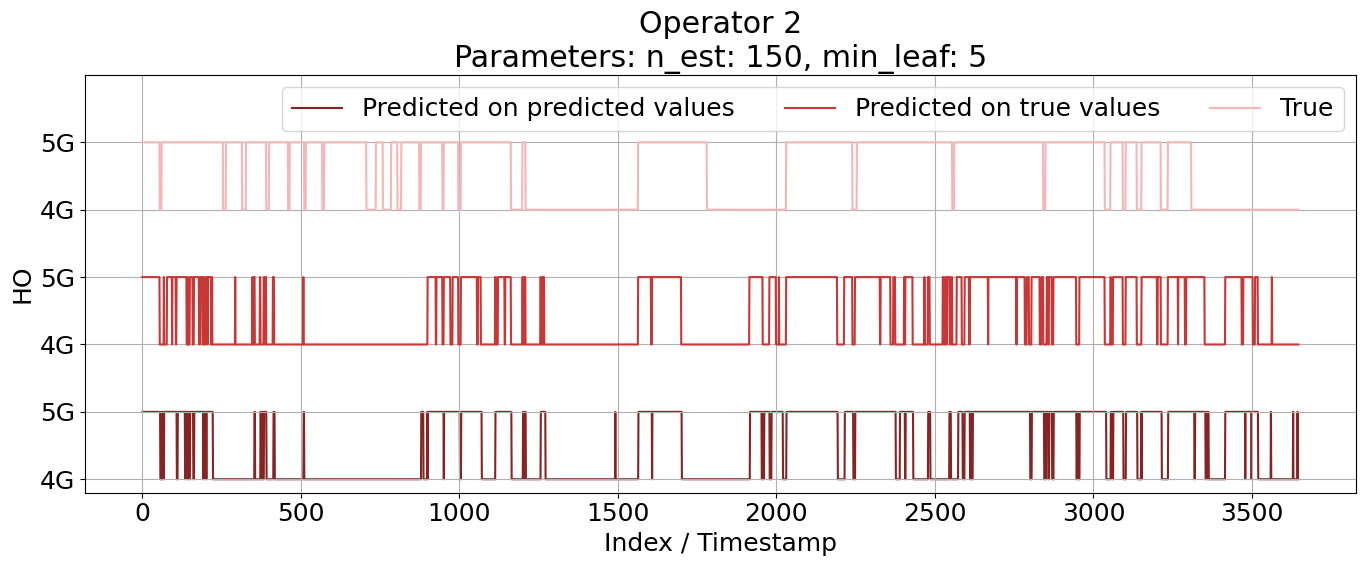

In [35]:
selected_rf_comb = 'n_est: 150, min_leaf: 5'
rf_comb = rf_results_2camp_loc[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']
pred_pred = rf_comb['pred_pred']

fig = plot_mode(pred=rf_pred, true=rf_true, preds=pred_pred, operator=operator, comb=selected_rf_comb)
fig.savefig(r'../latex/plots/rf_loc/op2_2campaign_loc.pdf')

#### Train 3 campaigns -- Test 1 campaign

In [25]:
train = clustered_df[clustered_df['campaign'].isin(overlap_1[1::])]
test = clustered_df[clustered_df['campaign'] == overlap_1[0]]

campaigns = train['campaign'].unique().tolist()
test_campaigns = test['campaign'].unique().tolist()

In [26]:
rf_results_3camp = {}
feats = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feats.append('campaign')
features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results_3camp[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, preds=lstm_preds_1camp[features], train_preds__=lstm_pred_train_1camp[features], n_steps_in=5, n_steps_out=1)

df_rf_results = pd.DataFrame.from_dict(rf_results_3camp, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  \
0      n_est: 5, min_leaf: 1     0.625      0.851   0.533   
1      n_est: 5, min_leaf: 5     0.630      0.803   0.592   
2     n_est: 5, min_leaf: 10     0.664      0.861   0.593   
3     n_est: 5, min_leaf: 15     0.680      0.876   0.607   
4     n_est: 10, min_leaf: 1     0.626      0.832   0.552   
5     n_est: 10, min_leaf: 5     0.665      0.885   0.575   
6    n_est: 10, min_leaf: 10     0.664      0.900   0.561   
7    n_est: 10, min_leaf: 15     0.678      0.878   0.602   
8     n_est: 50, min_leaf: 1     0.656      0.890   0.555   
9     n_est: 50, min_leaf: 5     0.668      0.903   0.564   
10   n_est: 50, min_leaf: 10     0.664      0.892   0.566   
11   n_est: 50, min_leaf: 15     0.687      0.896   0.602   
12   n_est: 100, min_leaf: 1     0.650      0.878   0.553   
13   n_est: 100, min_leaf: 5     0.661      0.881   0.570   
14  n_est: 100, min_leaf: 10     0.676      0.892   0.588   
15  n_est: 100, min_leaf: 15     0.675      0.907   0.572   
16   n_est: 120, min_leaf: 1     0.663      0.896   0.561   
17   n_est: 120, min_leaf: 5     0.665      0.897   0.564   
18  n_est: 120, min_leaf: 10     0.668      0.905   0.563   
19  n_est: 120, min_leaf: 15     0.675      0.903   0.575   
20   n_est: 150, min_leaf: 1     0.665      0.896   0.565   
21   n_est: 150, min_leaf: 5     0.662      0.897   0.559   
22  n_est: 150, min_leaf: 10     0.672      0.903   0.571   
23  n_est: 150, min_leaf: 15     0.670      0.890   0.579   
24   n_est: 200, min_leaf: 1     0.648      0.878   0.551   
25   n_est: 200, min_leaf: 5     0.668      0.894   0.572   
26  n_est: 200, min_leaf: 10     0.670      0.893   0.575   
27  n_est: 200, min_leaf: 15     0.674      0.888   0.586   

                                            pred_pred  \
0   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...   
1   [[0], [1], [1], [1], [1], [1], [1], [1], [1], ...   
2   [[0], [1], [1], [1], [1], [1], [1], [1], [1], ...   
3   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
4   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
5   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
6   [[1], [0], [1], [1], [1], [1], [1], [1], [1], ...   
7   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
8   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
9   [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
10  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
11  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
12  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
13  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
14  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
15  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
16  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
17  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
18  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
19  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
20  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
21  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
22  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
23  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
24  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
25  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
26  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   
27  [[1], [1], [1], [1], [1], [1], [1], [1], [1], ...   

                                      train_pred_pred  Accuracy_train  \
0   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.999   
1   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.995   
2   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.990   
3   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.987   
4   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.999   
5   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.996   
6   [[0], [0], [0], [0], [0], [0], [0], [0], [0], ...           0.991   
7   [[0], 

In [27]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.663
Mean precision: 0.884
Mean recall: 0.572


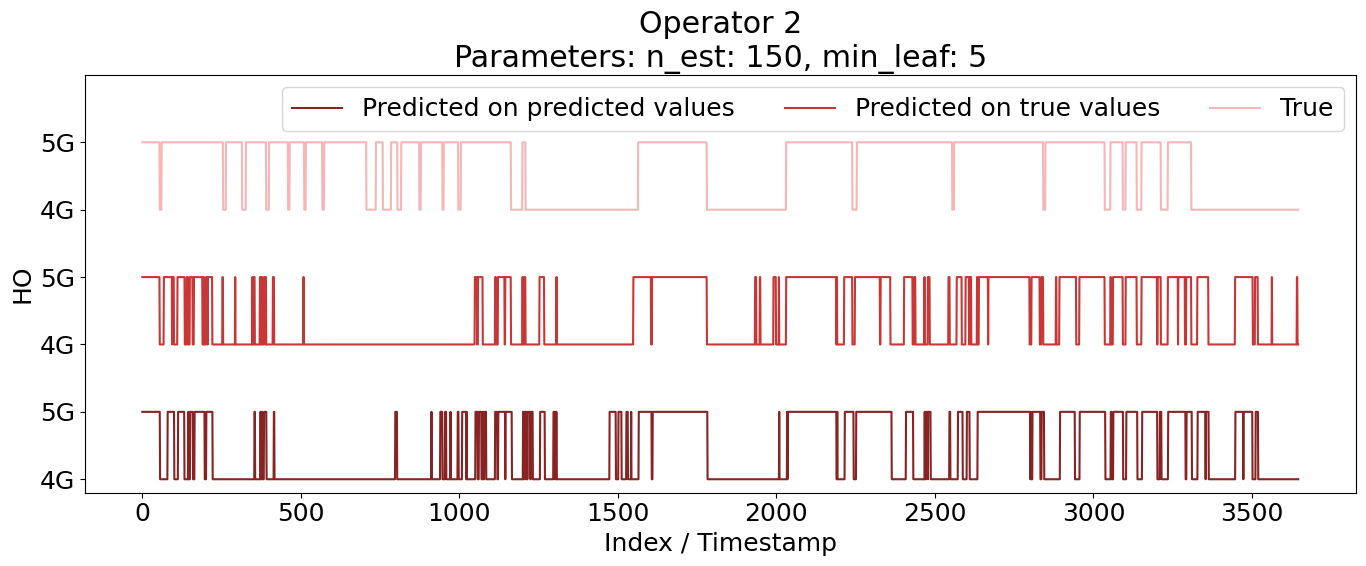

In [28]:
selected_rf_comb = 'n_est: 150, min_leaf: 5'
rf_comb = rf_results_3camp[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']
pred_pred = rf_comb['pred_pred']

fig = plot_mode(pred=rf_pred, true=rf_true, preds=pred_pred, operator=operator, comb=selected_rf_comb)
fig.savefig(r'../latex/plots/rf/op2_3campaign.pdf')

#### Include location

In [29]:
rf_results_3camp_loc = {}
feats = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
feats.extend(['campaign', 'k_area'])
features = ['RSRP', 'SINR', 'RSRQ', 'SSS_RSRP', 'SSS_SINR', 'SSS_RSRQ']
features.extend(['k_area'])

for est in est_try:
    for leaf in min_leaf_size:
        warnings.simplefilter(action='ignore')
        rf_results_3camp_loc[f'n_est: {est}, min_leaf: {leaf}'] = rf(X_train=train[feats], X_test=test[feats], mode_train=train[['Mode', 'campaign']], mode_test=test[['Mode', 'campaign']], campaigns=campaigns, test_campaigns=test_campaigns, n_estimators=est, min_samples_leaf=leaf, features=features, preds=lstm_preds_1camp, train_preds__=lstm_pred_train_1camp, n_steps_in=5, n_steps_out=1)

df_rf_results = pd.DataFrame.from_dict(rf_results_3camp_loc, orient='index')
df_rf_results.reset_index(inplace=True)
df_rf_results.rename(columns={'index': 'Parameters'}, inplace=True)
df_rf_results = df_rf_results.drop(['y_true', 'y_pred', 'train_true', 'train_pred', 'model', 'pred_pred', 'train_pred_pred'], axis=1)
df_rf_results

Parameters  Accuracy  Precision  Recall  Accuracy_train  \
0      n_est: 5, min_leaf: 1     0.635      0.834   0.567           0.999   
1      n_est: 5, min_leaf: 5     0.674      0.901   0.576           0.996   
2     n_est: 5, min_leaf: 10     0.652      0.886   0.551           0.989   
3     n_est: 5, min_leaf: 15     0.656      0.885   0.558           0.983   
4     n_est: 10, min_leaf: 1     0.666      0.893   0.570           0.999   
5     n_est: 10, min_leaf: 5     0.674      0.893   0.583           0.997   
6    n_est: 10, min_leaf: 10     0.674      0.911   0.568           0.996   
7    n_est: 10, min_leaf: 15     0.681      0.896   0.592           0.990   
8     n_est: 50, min_leaf: 1     0.679      0.923   0.567           0.999   
9     n_est: 50, min_leaf: 5     0.674      0.907   0.571           0.996   
10   n_est: 50, min_leaf: 10     0.672      0.913   0.562           0.993   
11   n_est: 50, min_leaf: 15     0.672      0.925   0.555           0.991   
12   n_est: 100, min_leaf: 1     0.671      0.927   0.552           0.999   
13   n_est: 100, min_leaf: 5     0.666      0.914   0.553           0.998   
14  n_est: 100, min_leaf: 10     0.681      0.925   0.570           0.995   
15  n_est: 100, min_leaf: 15     0.683      0.927   0.571           0.991   
16   n_est: 120, min_leaf: 1     0.674      0.916   0.564           0.999   
17   n_est: 120, min_leaf: 5     0.678      0.918   0.570           0.997   
18  n_est: 120, min_leaf: 10     0.667      0.910   0.557           0.995   
19  n_est: 120, min_leaf: 15     0.689      0.927   0.582           0.990   
20   n_est: 150, min_leaf: 1     0.674      0.925   0.558           0.999   
21   n_est: 150, min_leaf: 5     0.668      0.921   0.552           0.997   
22  n_est: 150, min_leaf: 10     0.679      0.923   0.568           0.996   
23  n_est: 150, min_leaf: 15     0.674      0.925   0.558           0.991   
24   n_est: 200, min_leaf: 1     0.672      0.926   0.553           0.999   
25   n_est: 200, min_leaf: 5     0.672      0.921   0.557           0.997   
26  n_est: 200, min_leaf: 10     0.689      0.930   0.578           0.995   
27  n_est: 200, min_leaf: 15     0.682      0.930   0.567           0.992   

    Precision_train  Recall_train  Accuracy_pred  Precision_pred  Recall_pred  \
0             0.999         0.998          0.647           0.590        0.835   
1             0.996         0.995          0.672           0.577        0.896   
2             0.988         0.988          0.669           0.596        0.869   
3             0.980         0.983          0.662           0.570        0.884   
4             0.999         0.998          0.635           0.539        0.865   
5             0.997         0.996          0.664           0.568        0.890   
6             0.997         0.996          0.678           0.576        0.909   
7             0.990         0.989          0.665           0.576        0.883   
8             0.999         0.999          0.671           0.567        0.906   
9             0.997         0.995          0.674           0.586        0.889   
10            0.992         0.994          0.665           0.566        0.895   
11            0.989         0.992          0.668           0.567        0.899   
12            0.999         0.999          0.677           0.572        0.913   
13            0.998         0.997          0.670           0.568        0.902   
14            0.993         0.995          0.672           0.577        0.895   
15            0.988         0.993          0.667           0.561        0.904   
16            0.999         0.999          0.668           0.569        0.896   
17            0.999         0.996          0.680           0.582        0.906   
18            0.995         0.995          0.671           0.577        0.893   
19            0.988         0.991          0.674           0.567        0.912   
20            0.999         0.999          0.664           0.563        0.896   
21

In [30]:
accuracy = df_rf_results['Accuracy'].mean()
precision = df_rf_results['Precision'].mean()
recall = df_rf_results['Recall'].mean()

print(f'Mean accuracy: {accuracy:.3f}\nMean precision: {precision:.3f}\nMean recall: {recall:.3f}')

Mean accuracy: 0.672
Mean precision: 0.912
Mean recall: 0.565


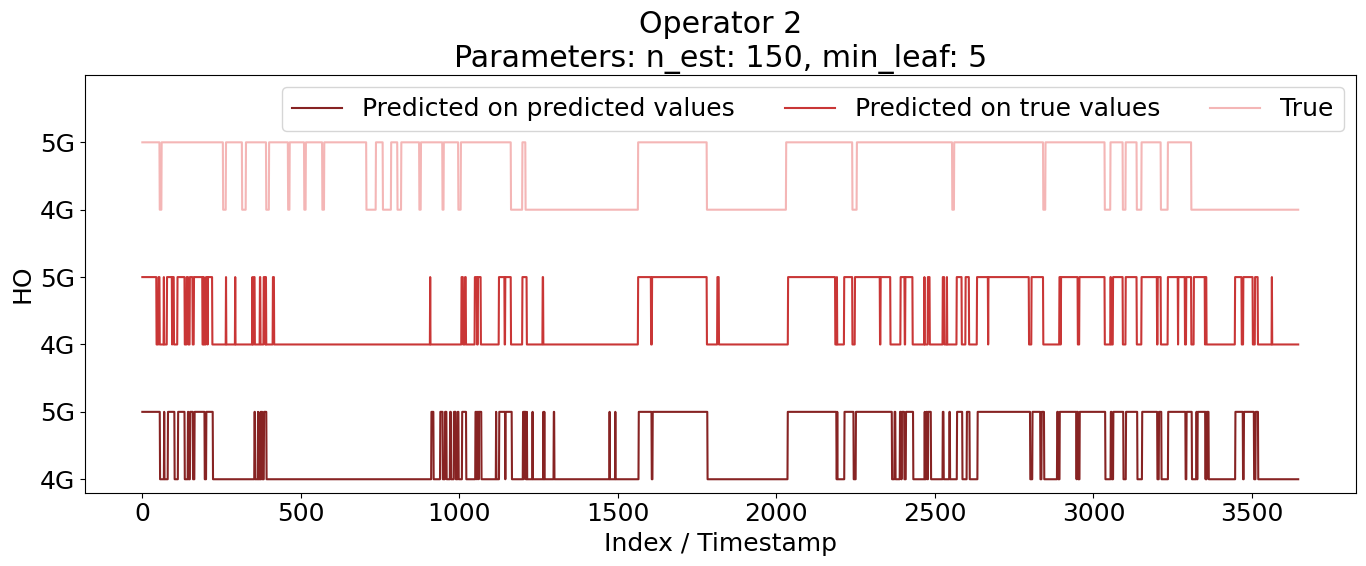

In [31]:
selected_rf_comb = 'n_est: 150, min_leaf: 5'
rf_comb = rf_results_3camp_loc[selected_rf_comb]
rf_pred = rf_comb['y_pred']
rf_true = rf_comb['y_true']
pred_pred = rf_comb['pred_pred']

fig = plot_mode(pred=rf_pred, true=rf_true, preds=pred_pred, operator=operator, comb=selected_rf_comb)
fig.savefig(r'../latex/plots/rf_loc/op2_3campaign_loc.pdf')